In [1]:
import sidrapy
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

In [2]:
# Importa as variações do IPCA
# Tabela 1737: https://sidra.ibge.gov.br/tabela/1737
#	Unidade Territorial - 1	Brasil
# Variáveis: 63	IPCA - Variação mensal, 69	IPCA - Variação acumulada no ano, 2263	IPCA - Variação acumulada em 3 meses, 
#            2264	IPCA - Variação acumulada em 6 meses, 2265	IPCA - Variação acumulada em 12 meses

ipca_raw = sidrapy.get_table(table_code = '1737',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,69,2263,2264,2265',
                             period = 'last%20472')

In [3]:
# Realiza a limpeza e manipulação da tabela
ipca =  (ipca_raw.loc[1:,['V', 'D2C', 'D3N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable'})
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'Var. mensal (%)',
                                                        'IPCA - Variação acumulada no ano': 'Var. acumulada no ano (%)', 
                                                        'IPCA - Variação acumulada em 3 meses' : 'Var. MM3M (%)',
                                                        'IPCA - Variação acumulada em 6 meses': 'Var. MM6M (%)',
                                                        'IPCA - Variação acumulada em 12 meses' : 'Var. MM12M (%)'}),
            date  = lambda x: pd.to_datetime(x['date'], format = "%Y%m"),
            value = lambda x: x['value'].astype(float))
    .pipe(lambda x: x.loc[x.date > '2007-01-01']))

In [4]:
# Configura o tema do gráfico
## Cores
colors = ['#282f6b', '#b22200', '#eace3f', '#224f20', '#b35c1e', '#419391', '#839c56','#3b89bc']

## Tamanho
theme = {'figure.figsize' : (15, 10)}

## Aplica o tema
sns.set_theme(rc = theme, palette = colors)

# Filtra somente para o IPCA acumulado em 12 meses
ipca_12m = (ipca.pipe(lambda x: x.loc[x.variable == 'Var. MM12M (%)']))

Text(1.0, -0.08, 'Fonte: dados do Sidra/IBGE')

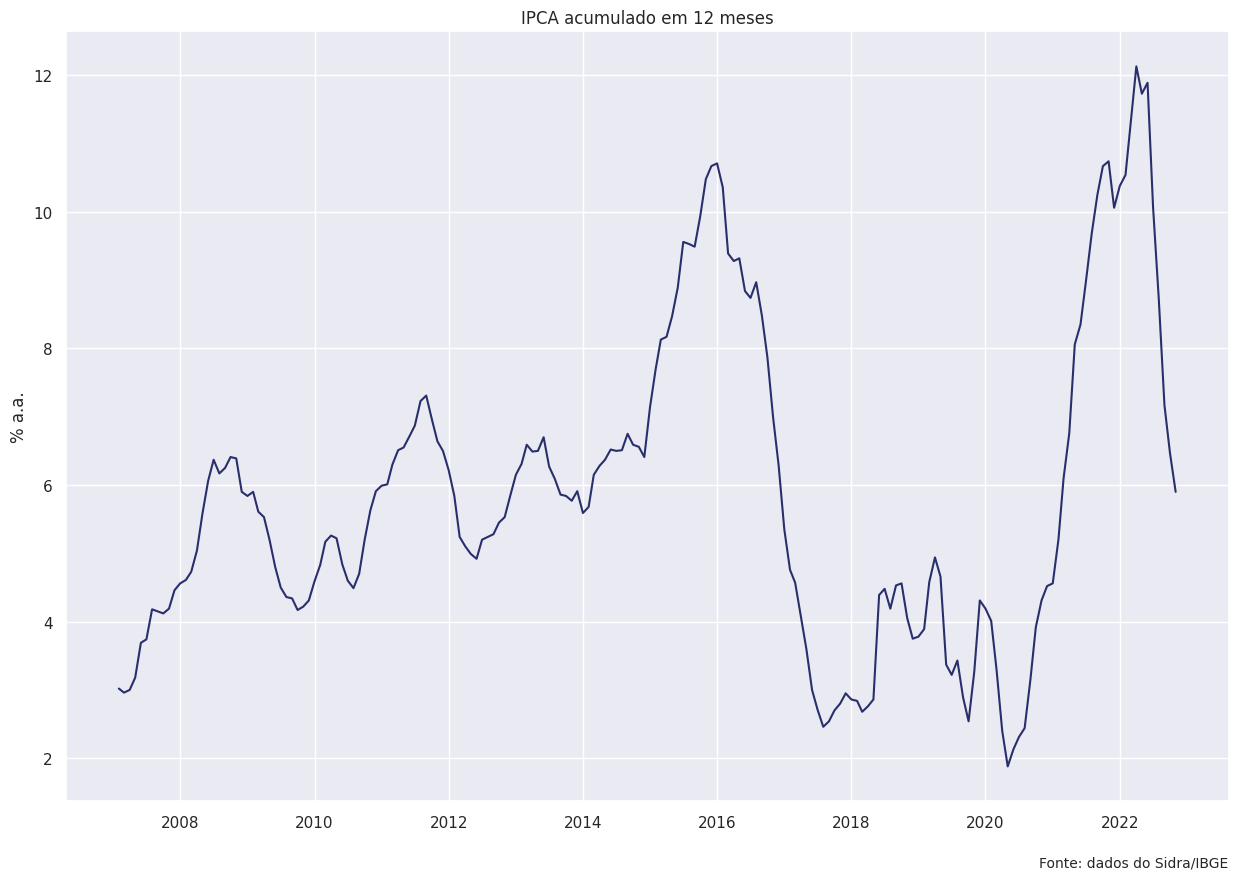

In [5]:
# Plota o IPCA acumulado em 12 meses
sns.lineplot(x = 'date',
             y = 'value',
             data = ipca_12m).set(title = 'IPCA acumulado em 12 meses',
                                                           xlabel = '',
                                                           ylabel = '% a.a.')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: dados do Sidra/IBGE',
            xy = (1.0, -0.08),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

Text(1.0, -0.13, 'Fonte: dados do Sidra/IBGE')

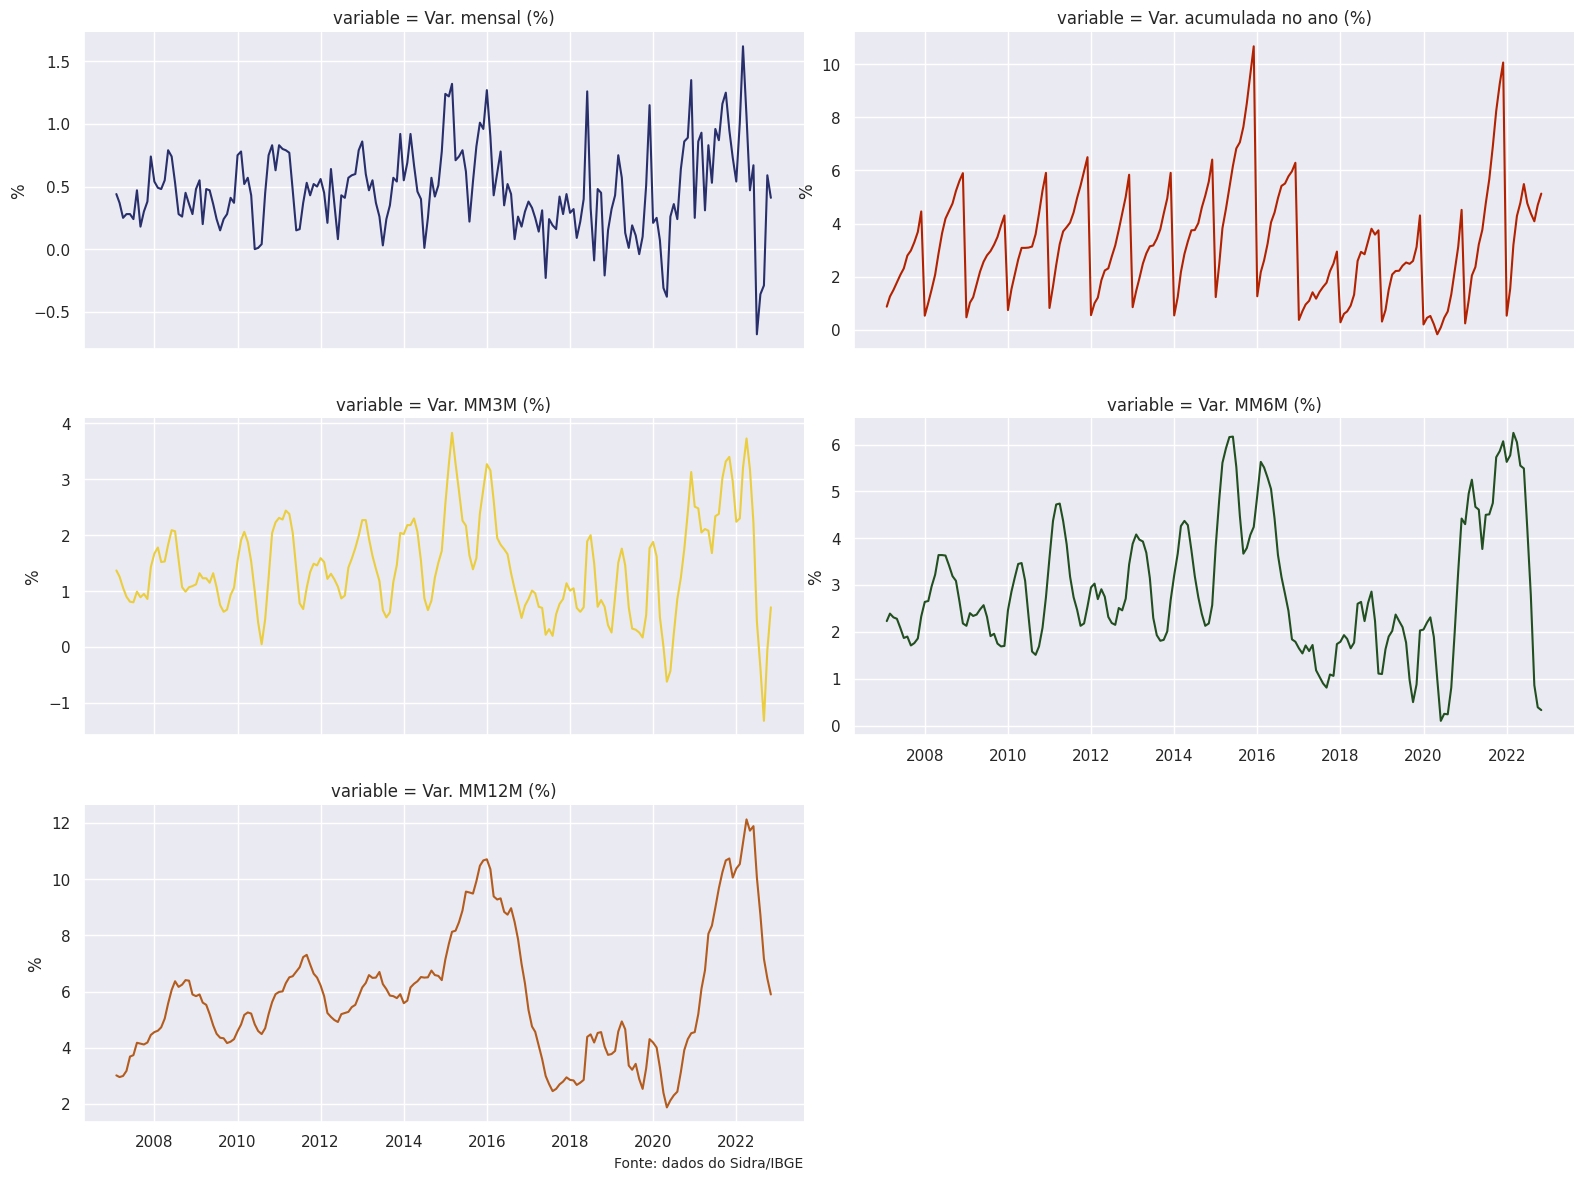

In [6]:
# Plota todas as variações
g = sns.FacetGrid(ipca, col = 'variable',
                  col_wrap = 2,
                  hue = 'variable',
                  sharey = False,
                  height = 4,
                  aspect = 2)


g.map_dataframe(sns.lineplot, 
                x = 'date',
                y = 'value').set(xlabel = "",
                                 ylabel = '%')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: dados do Sidra/IBGE',
            xy = (1.0, -0.13),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

In [7]:
# Importa as variações e os pesos dos grupos do IPCA
ipca_gp_raw = sidrapy.get_table(table_code = '7060',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,66',
                             period = 'all',
                             classification = '315/7170,7445,7486,7558,7625,7660,7712,7766,7786'
                             )

In [8]:
# Realiza a limpeza e manipulação da tabela
ipca_gp =  (
    ipca_gp_raw
    .loc[1:,['V', 'D2C', 'D3N', 'D4N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable',
                       'D4N': 'groups'})
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'variacao',
                                                        'IPCA - Peso mensal': 'peso'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float),
            groups = lambda x: x['groups'].astype(str)
           )
    .pipe(lambda x: x.loc[x.date > '2007-01-01'])
)

In [9]:
# Torna em formato wide e calcula a contribuição de cada grupo pro IPCA
ipca_gp_wider = (
    ipca_gp
    .pivot_table(index = ['date', 'groups'],
                 columns = 'variable',
                 values = 'value')
    .reset_index()
    .assign(contribuicao = lambda x: (x.peso * x.variacao) / 100)
)

In [10]:
# Plota a contribuição de cada grupo com plotly
px.bar(ipca_gp_wider,
       x = 'date',
       y = 'contribuicao',
       color = 'groups',
       color_discrete_sequence = colors)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf6f5887-9730-4d73-8b48-f465b0268709' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>